In [24]:
import cv2
import torch
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt




In [ ]:
class DataLoader():
    

In [25]:
path_dir = '/Users/lukassanner/Documents/ZeissHackathon/photomask_trainingdata'

dirs = os.listdir(path_dir)[1:]

data = {}

for d in dirs:
    folder_dir = os.path.join(path_dir,d)
    files = os.listdir(folder_dir)

    tifs = []
    for f in files:
        if f.endswith('.tif'):
            tifs.append(os.path.join(folder_dir, f))
    data[d] = tifs


In [77]:
dirs


['COMPLETE FEATURE', 'BORDERTOUCHER', 'NO FEATURE']

In [86]:


def blur(img, kernel_size=10):
    kernel = np.ones((kernel_size,kernel_size),np.float32)/(kernel_size**2)
    return cv2.filter2D(img,-1,kernel)

def edge_detection(img):
    return cv2.Canny(blur(img), 50, 100)


def cv2_segment(image, t=100):
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

    return binary

def find_contours(segmentation):
    _, contours, _ = cv2.findContours(segmentation, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)
    return contours

def draw_contours(img, contours):
    image = img.copy()
    blank = np.zeros(img.shape)
    cv2.drawContours(blank, contours, -1, (255,0,0), 2)
    return blank

In [148]:
def findEllipses(image):
    segmentation = cv2_segment(image)
    contours = find_contours(segmentation)
    #contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    ellipseMask = np.zeros(image.shape, dtype=np.uint8)
    contourMask = np.zeros(image.shape, dtype=np.uint8)

    pi_4 = np.pi * 4
    ellipses_contour = image.copy()
    for i, contour in enumerate(contours):
        if len(contour) < 5:
            continue

        area = cv2.contourArea(contour)
        if area <= 100:  # skip ellipses smaller then 10x10
            continue

        arclen = cv2.arcLength(contour, True)
        circularity = (pi_4 * area) / (arclen * arclen)
        ellipse = ellipses_of_contour(contour)
        #  ellipse = cv2.fitEllipse(contour)
        #print(ellipse)

        cv2.ellipse(ellipses_contour,ellipse,(0,255,0),2)
        poly = cv2.ellipse2Poly((int(ellipse[0][0]), int(ellipse[0][1])), (int(ellipse[1][0] / 2), int(ellipse[1][1] / 2)), int(ellipse[2]), 0, 360, 5)

        # if contour is circular enough
        if circularity > 0.6:
            cv2.fillPoly(ellipseMask, [poly], 255)
            continue

        # if contour has enough similarity to an ellipse
        similarity = cv2.matchShapes(poly.reshape((poly.shape[0], 1, poly.shape[1])), contour, cv2.CONTOURS_MATCH_I2, 0)
        if similarity <= 0.2:
            cv2.fillPoly(contourMask, [poly], 255)

    return ellipses_contour,ellipseMask, contourMask 


def ellipses_of_contour(contour):
    return cv2.fitEllipse(contour)
    
def attributes_of_ellipses(ellipses):
    center = ellipses[0]
    axis = ellipses[1]
    angle = ellipses[2]
    area = np.pi * axis[0] * axis[1]
    return center, axis, angle, area
    

0 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


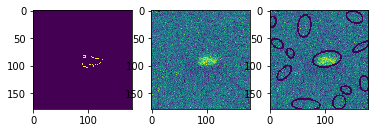

In [149]:
im = Image.open(data['COMPLETE FEATURE'][10])
im = np.array(im)
ellipses, ell, cont = findEllipses(im)
print(np.sum(ell), ell)
fig, axs = plt.subplots(1,3)
axs[0].imshow(edge_detection(im))
axs[1].imshow(im)
axs[2].imshow(ellipses)

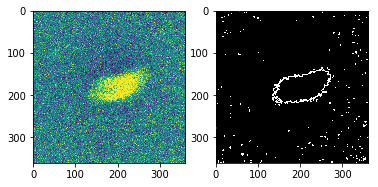

In [88]:
im = Image.open(data['COMPLETE FEATURE'][50])
im = np.array(im)

segment = cv2_segment(im, t=150)
contour = find_contours(segment)
im_cont = draw_contours(im, contour)

fig, axs = plt.subplots(1,2)
axs[0].imshow(im)
axs[1].imshow(im_cont, cmap='gray')

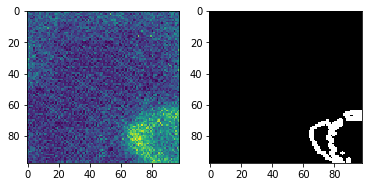

In [91]:
im = Image.open(data['BORDERTOUCHER'][10])
im = np.array(im)

segment = cv2_segment(im, t=150)
contour = find_contours(segment)
im_cont = draw_contours(im, contour)

fig, axs = plt.subplots(1,2)
axs[0].imshow(im)
axs[1].imshow(im_cont, cmap='gray')

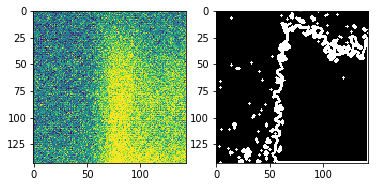

In [92]:
im = Image.open(data['NO FEATURE'][10])
im = np.array(im)
segment = cv2_segment(im, t=150)
contour = find_contours(segment)
im_cont = draw_contours(im, contour)

fig, axs = plt.subplots(1,2)
axs[0].imshow(im)
axs[1].imshow(im_cont, cmap='gray')